# Evaluate saved model on `data/test_200.h5` and plot residual violins

This notebook evaluates the saved model on the provided test file `../data/test_200.h5`. Steps:
1. Inspect checkpoint (`../pytorch_models/cnn_model.pth`) for normalization stats.
2. Build a `SpectralDataset` from `data/test_normalised.h5` and a test DataLoader.
3. Load the model weights and run inference on the test set.
4. Inverse-transform predictions (using dataset helper or saved mean/std) and save `results/test_predictions.npz`.
5. Produce binned violin plots of residuals for the available target parameters.


In [12]:
# Cell 1: Setup paths and imports
%matplotlib inline
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import sys
import torch
from torch.utils.data import DataLoader
import inspect
import pandas as pd
from scipy import stats

# Paths (adjust if needed)
PROJECT_ROOT = Path('..').resolve()          # notebook lives in results/
sys.path.insert(0, str(PROJECT_ROOT))
TEST_HDF5_PATH = PROJECT_ROOT / 'data' / 'test_normalised.h5'
MODEL_PTH = PROJECT_ROOT / 'pytorch_models' / 'cnn_model.pth'
OUT_DIR = PROJECT_ROOT / 'results'
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Runtime settings
BATCH_SIZE = 64
DEVICE = 'cpu'   # change to 'cuda' if you have GPU and want to use it

print('Test HDF5:', TEST_HDF5_PATH)
print('Checkpoint:', MODEL_PTH)
print('Output dir:', OUT_DIR)

Test HDF5: /lustre06/project/6016730/minjihk/WEAVE_Pristine/data/test_normalised.h5
Checkpoint: /lustre06/project/6016730/minjihk/WEAVE_Pristine/pytorch_models/cnn_model.pth
Output dir: /lustre06/project/6016730/minjihk/WEAVE_Pristine/results


Loaded keys: ['train_loss', 'val_loss', 'grad_norm_mean', 'grad_norm_max', 'grad_norm_min']
train_loss shape: (20,)
val_loss shape: (20,)


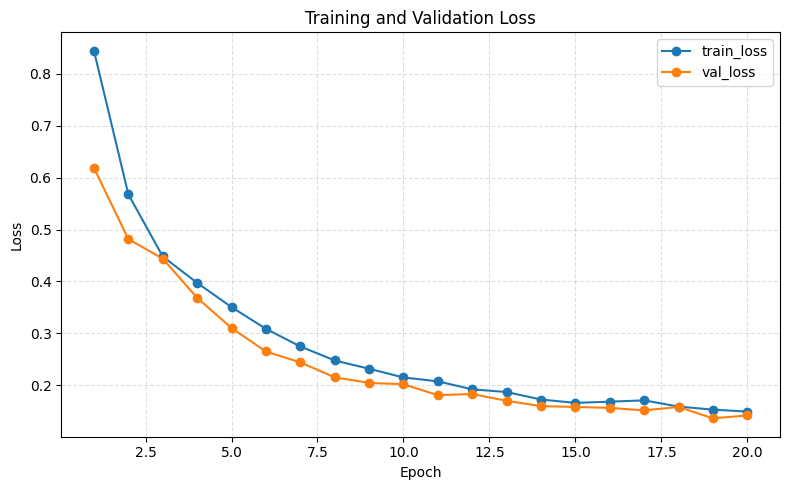

In [2]:
# Cell 2: Plot loss curves (train vs validation)

# Path to the .npz history file - edit this if needed
HISTORY_PATH = Path('../pytorch_models/cnn_model.history.npz')

def plot_loss_curves(history_path):
    if not history_path.exists():
        raise FileNotFoundError(f'History file not found: {history_path}')

    data = np.load(history_path, allow_pickle=True)
    print('Loaded keys:', list(data.keys()))

    train_loss = data['train_loss']
    val_loss = data['val_loss']

    print(f'train_loss shape: {train_loss.shape}')
    print(f'val_loss shape: {val_loss.shape}')

    fig, ax = plt.subplots(figsize=(8, 5))
    epochs = np.arange(1, len(train_loss) + 1)
    ax.plot(epochs, train_loss, marker='o', label='train_loss')
    ax.plot(epochs, val_loss, marker='o', label='val_loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training and Validation Loss')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

plot_loss_curves(HISTORY_PATH)

In [3]:
# Cell 2: Inspect checkpoint for normalization stats
if not MODEL_PTH.exists():
    raise FileNotFoundError(f'Checkpoint not found: {MODEL_PTH}')

# Load checkpoint (if not loaded already)
if 'ckpt' not in globals():
    # If you previously used safe_globals, keep that approach. Here we just attempt a normal load:
    ckpt = torch.load(MODEL_PTH, map_location=DEVICE, weights_only=False)

print('Checkpoint type:', type(ckpt))
if isinstance(ckpt, dict):
    print('Checkpoint keys:', list(ckpt.keys()))
    has_mean_std = ('target_mean' in ckpt) and ('target_std' in ckpt)
    print('Has target_mean/std in ckpt? ->', has_mean_std)
else:
    print('Checkpoint is not a dict (likely a raw state_dict). No saved mean/std available.')

globals()['ckpt'] = ckpt

Checkpoint type: <class 'dict'>
Checkpoint keys: ['model_state_dict', 'target_mean', 'target_std', 'input_length', 'output_size', 'kernel_size']
Has target_mean/std in ckpt? -> True


In [4]:
# Cell 3: Instantiate SpectralDataset using the test HDF5 file, and create a DataLoader
try:
    from pytorch_models.spectral_dataset import SpectralDataset, SpectralTransforms
    print('Imported SpectralDataset')
except Exception as e:
    raise RuntimeError('Could not import SpectralDataset from pytorch_models.spectral_dataset: ' + str(e)) from e

# Create dataset (ensure the target_key and use_target_indices match training)
test_dataset = SpectralDataset(
    hdf5_filepath=TEST_HDF5_PATH,
    load_targets=True,
    target_key='original_stellar_parameters',   # adjust if test file uses different key
    use_target_indices=[0, 1, 2, 3],            # Teff, logg, [Fe/H], [a/Fe] (match training)
    transform=SpectralTransforms.standardize,
    device=DEVICE
)

# Apply checkpoint target_mean/target_std to dataset so dataset returns normalized targets
ck = globals().get('ckpt') or globals().get('ck')
if isinstance(ck, dict) and ('target_mean' in ck) and ('target_std' in ck):
    mean = np.array(ck['target_mean'])
    std = np.array(ck['target_std'])
    if hasattr(test_dataset, 'set_target_stats'):
        test_dataset.set_target_stats(mean, std)
        print('Applied checkpoint target_mean/std to `test_dataset` (targets will be normalized).')
    else:
        print('Warning: test_dataset has no set_target_stats method; cannot apply ckpt normalization.')
else:
    print('No target_mean/target_std found in checkpoint; leaving test_dataset target behavior unchanged.')

print('Test dataset length:', len(test_dataset))
globals()['test_dataset'] = test_dataset

Imported SpectralDataset
Data validation passed
SpectralDataset initialized:
  File: /lustre06/project/6016730/minjihk/WEAVE_Pristine/data/test_normalised.h5
  Spectra: 199
  Wavelength points: 6487
  Wavelength range: 4851.92 - 4885.00 Å
  Flux key: flux_normalized
  Load targets: True
  Target key: original_stellar_parameters
  Using target indices: [0, 1, 2, 3]
  Device: cpu
Setting target normalization statistics...
  Mean: [ 5.7365981e+03  3.5043838e+00 -2.2244849e+00  1.2525773e+00]
  Std: [9.9166724e+02 1.0220170e+00 1.5957007e+00 4.3449137e-01]
Applied checkpoint target_mean/std to `test_dataset` (targets will be normalized).
Test dataset length: 199


In [5]:
# Recreate a safe test_loader (no worker processes, small batch)
from torch.utils.data import DataLoader

SAFE_BATCH_SIZE = 16
print('Recreating test_loader with num_workers=0, batch_size=', SAFE_BATCH_SIZE)

test_loader = DataLoader(
    globals().get('test_dataset'),
    batch_size=SAFE_BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

globals()['test_loader'] = test_loader

# Try fetching one batch to verify the dataset returns normalized targets (if applied)
try:
    batch = next(iter(test_loader))
    print('Successfully fetched one batch; type:', type(batch))
    # show shapes/types for inspection
    if isinstance(batch, dict):
        for k, v in batch.items():
            try:
                print(f"  {k}: type={type(v)}, shape={getattr(v, 'shape', 'scalar')}")
            except Exception:
                print(f"  {k}: type={type(v)}")
    elif isinstance(batch, (list, tuple)):
        for i, el in enumerate(batch):
            try:
                print(f'  element {i}: type={type(el)}, shape={getattr(el, "shape", "scalar")}')
            except Exception:
                print(f'  element {i}: type={type(el)}')
    else:
        print('Batch object type:', type(batch))
except Exception as e:
    print('Error while fetching a batch from test_loader (shows exception):', repr(e))

Recreating test_loader with num_workers=0, batch_size= 16
Successfully fetched one batch; type: <class 'list'>
  element 0: type=<class 'torch.Tensor'>, shape=torch.Size([16, 6487])
  element 1: type=<class 'torch.Tensor'>, shape=torch.Size([16, 4])


In [6]:
# Load CNN class and weights, prepare inverse-transform helper (adapted for your CNN signature)
from importlib import import_module

# Try to import the training CNN class
mod = import_module('pytorch_models.cnn')
CNN_class_choice = getattr(mod, 'CNN', None)
print('Found CNN in pytorch_models.cnn ->', CNN_class_choice is not None)
if CNN_class_choice is None:
    raise RuntimeError("Could not find `CNN` class in pytorch_models.cnn")

# Get checkpoint and infer expected sizes
ck = globals().get('ckpt') or globals().get('ck')
input_length = None
output_size = None
kernel_size = None

if isinstance(ck, dict):
    # try a few common key names that might have been saved
    input_length = ck.get('input_length', ck.get('input_size', ck.get('n_input', None)))
    output_size = ck.get('output_size', ck.get('output_dim', ck.get('n_output', ck.get('output_size', None))))
    kernel_size = ck.get('kernel_size', ck.get('filter_len', ck.get('filter_length', None)))

# Fallback sizes from dataset if not in checkpoint
if input_length is None:
    try:
        input_length = int(test_dataset.n_wavelengths)
    except Exception:
        input_length = None
if output_size is None:
    try:
        output_size = int(test_dataset.n_targets)
    except Exception:
        output_size = None

# Final fallbacks / defaults
if input_length is None:
    input_length = 1
    print("Warning: input_length unknown, defaulting to 1")
if output_size is None:
    output_size = 1
    print("Warning: output_size unknown, defaulting to 1")
if kernel_size is None:
    kernel_size = 8  # sensible default if not stored
    print(f"Warning: kernel_size not found in checkpoint, defaulting to {kernel_size}")

print('Model params -> input_length:', input_length, 'output_size:', output_size, 'kernel_size:', kernel_size)

# Instantiate model (defensive; try keyword form first, then positional permutations)
model = None
instantiation_errors = []
try:
    model = CNN_class_choice(kernel_size=kernel_size, input_length=input_length, output_size=output_size)
except TypeError as e:
    instantiation_errors.append(e)
    try:
        # older/alternate ordering: (input_length, output_size, kernel_size)
        model = CNN_class_choice(input_length, output_size, kernel_size)
    except TypeError as e2:
        instantiation_errors.append(e2)
        try:
            # (kernel_size, input_length, output_size)
            model = CNN_class_choice(kernel_size, input_length, output_size)
        except Exception as e3:
            instantiation_errors.append(e3)
            # last resort: try calling with only input/output and hope kernel_size default matches
            try:
                model = CNN_class_choice(input_length=input_length, output_size=output_size)
            except Exception as e4:
                instantiation_errors.append(e4)

if model is None:
    print("Failed instantiating CNN with attempted signatures. Errors collected:")
    for i, err in enumerate(instantiation_errors):
        print(i, repr(err))
    raise RuntimeError("Unable to instantiate CNN class with inferred parameters.")

print("Instantiated CNN:", model)

# Load weights (support both raw state_dict and checkpoint-dict)
saved_state = ck.get('model_state_dict') if isinstance(ck, dict) and 'model_state_dict' in ck else ck
try:
    model.load_state_dict(saved_state, strict=True)
    print('Loaded state_dict with strict=True')
except Exception as e:
    print('Strict load failed, retrying with strict=False. Error:', e)
    load_res = model.load_state_dict(saved_state, strict=False)
    print('Load result missing/unexpected keys:', getattr(load_res, 'missing_keys', None), getattr(load_res, 'unexpected_keys', None))

# move to device and set eval mode
model = model.to(DEVICE)
model.eval()

print('Model loaded. Ready for inference.')

Found CNN in pytorch_models.cnn -> True
Model params -> input_length: 6487 output_size: 4 kernel_size: 8
Instantiated CNN: CNN(
  (conv1): Conv1d(1, 4, kernel_size=(8,), stride=(1,))
  (conv2): Conv1d(4, 16, kernel_size=(8,), stride=(1,))
  (pool): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc_layers): Sequential(
    (0): Linear(in_features=25888, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=4, bias=True)
  )
)
Loaded state_dict with strict=True
Model loaded. Ready for inference.


In [7]:
# Safer inference loop: collect raw preds and truths, then convert both to physical units
import torch

model = globals().get('model')
if model is None:
    raise RuntimeError('No model found in globals; run the model-loading cell first.')
model = model.to(DEVICE)
model.eval()

test_loader = globals().get('test_loader')
if test_loader is None:
    raise RuntimeError('No test_loader found. Run the safe loader cell first.')

# inverse-transform helper (prefer dataset method, then checkpoint mean/std)
ck = globals().get('ckpt') or globals().get('ck')
ds = globals().get('test_dataset', None)

def inverse_targets_np(arr_np):
    # prefer dataset.inverse_transform_target if available
    if ds is not None and hasattr(ds, 'inverse_transform_target'):
        try:
            import torch as _torch
            return ds.inverse_transform_target(_torch.from_numpy(arr_np)).cpu().numpy()
        except Exception:
            pass
    if isinstance(ck, dict):
        mean = ck.get('target_mean', None)
        std = ck.get('target_std', None)
        if mean is not None and std is not None:
            mean = np.array(mean)
            std = np.array(std)
            return arr_np * std + mean
    return arr_np

pred_chunks = []
truth_chunks = []
index_chunks = []
collected_indices = False

iterator = test_loader

try:
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            try:
                # normalize batch parsing to (inputs, targets, maybe indices)
                if isinstance(batch, dict):
                    inputs = batch.get('inputs') or batch.get('spectra') or batch.get('x') or batch.get('data')
                    targets = batch.get('targets') or batch.get('y') or batch.get('labels')
                    batch_idx = batch.get('indices') or batch.get('idx') or batch.get('index')
                elif isinstance(batch, (list, tuple)):
                    if len(batch) == 2:
                        inputs, targets = batch
                        batch_idx = None
                    else:
                        inputs, targets, batch_idx = batch[0], batch[1], (batch[2] if len(batch) > 2 else None)
                else:
                    raise RuntimeError(f'Unsupported batch type: {type(batch)}')

                # convert numpy to tensor if needed
                if isinstance(inputs, np.ndarray):
                    inputs = torch.from_numpy(inputs)
                if isinstance(targets, np.ndarray):
                    targets = torch.from_numpy(targets)

                inputs = inputs.to(DEVICE)
                targets = targets.to(DEVICE)

                outputs = model(inputs)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]

                # collect raw numpy arrays
                preds_raw = outputs.cpu().numpy()
                truths_raw = targets.cpu().numpy()

                pred_chunks.append(preds_raw)
                truth_chunks.append(truths_raw)

                if 'batch_idx' in locals() and batch_idx is not None:
                    collected_indices = True
                    if isinstance(batch_idx, torch.Tensor):
                        index_chunks.append(batch_idx.cpu().numpy())
                    elif isinstance(batch_idx, (list, np.ndarray)):
                        index_chunks.append(np.array(batch_idx))
                    else:
                        index_chunks.append(np.array([batch_idx]))

            except Exception as batch_exc:
                print(f'Error in batch {i}:', repr(batch_exc))
except Exception as e:
    print('Unexpected error during inference loop (caught):', repr(e))

# Concatenate
if len(pred_chunks) == 0:
    raise RuntimeError('No predictions collected (maybe all batches errored).')

preds_raw = np.concatenate(pred_chunks, axis=0)
truths_raw = np.concatenate(truth_chunks, axis=0)
if collected_indices and len(index_chunks) > 0:
    indices = np.concatenate(index_chunks, axis=0)
else:
    ds_for_indices = getattr(test_loader, 'dataset', None)
    if ds_for_indices is not None and hasattr(ds_for_indices, 'indices'):
        indices = np.array(ds_for_indices.indices)
    else:
        indices = np.arange(len(preds_raw))

print('Collected raw preds shape:', preds_raw.shape, 'raw truths shape:', truths_raw.shape, 'indices shape:', indices.shape)

# Apply inverse transform to both preds and truths to get physical units
preds_phys = inverse_targets_np(preds_raw)
truths_phys = inverse_targets_np(truths_raw)
residuals_phys = preds_phys - truths_phys

out_npz = Path('..') / 'results' / 'cnn_test_predictions_normalized_labels.npz'
np.savez(out_npz,
         indices=indices,
         preds_raw=preds_raw,
         truths_raw=truths_raw,
         preds_phys=preds_phys,
         truths_phys=truths_phys,
         residuals_phys=residuals_phys)
print('Saved test predictions (raw + physical) to', out_npz)

# expose in globals for plotting cells
globals()['test_preds_raw'] = preds_raw
globals()['test_truths_raw'] = truths_raw
globals()['test_preds'] = preds_phys        # keep notebook compatibility (test_preds = physical preds)
globals()['test_truths'] = truths_phys
globals()['test_residuals'] = residuals_phys
globals()['indices'] = indices

Collected raw preds shape: (199, 4) raw truths shape: (199, 4) indices shape: (199,)
Saved test predictions (raw + physical) to ../results/cnn_test_predictions_normalized_labels.npz


/tmp/ipykernel_3168292/457530375.py:177: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(x) for x in tick_positions])


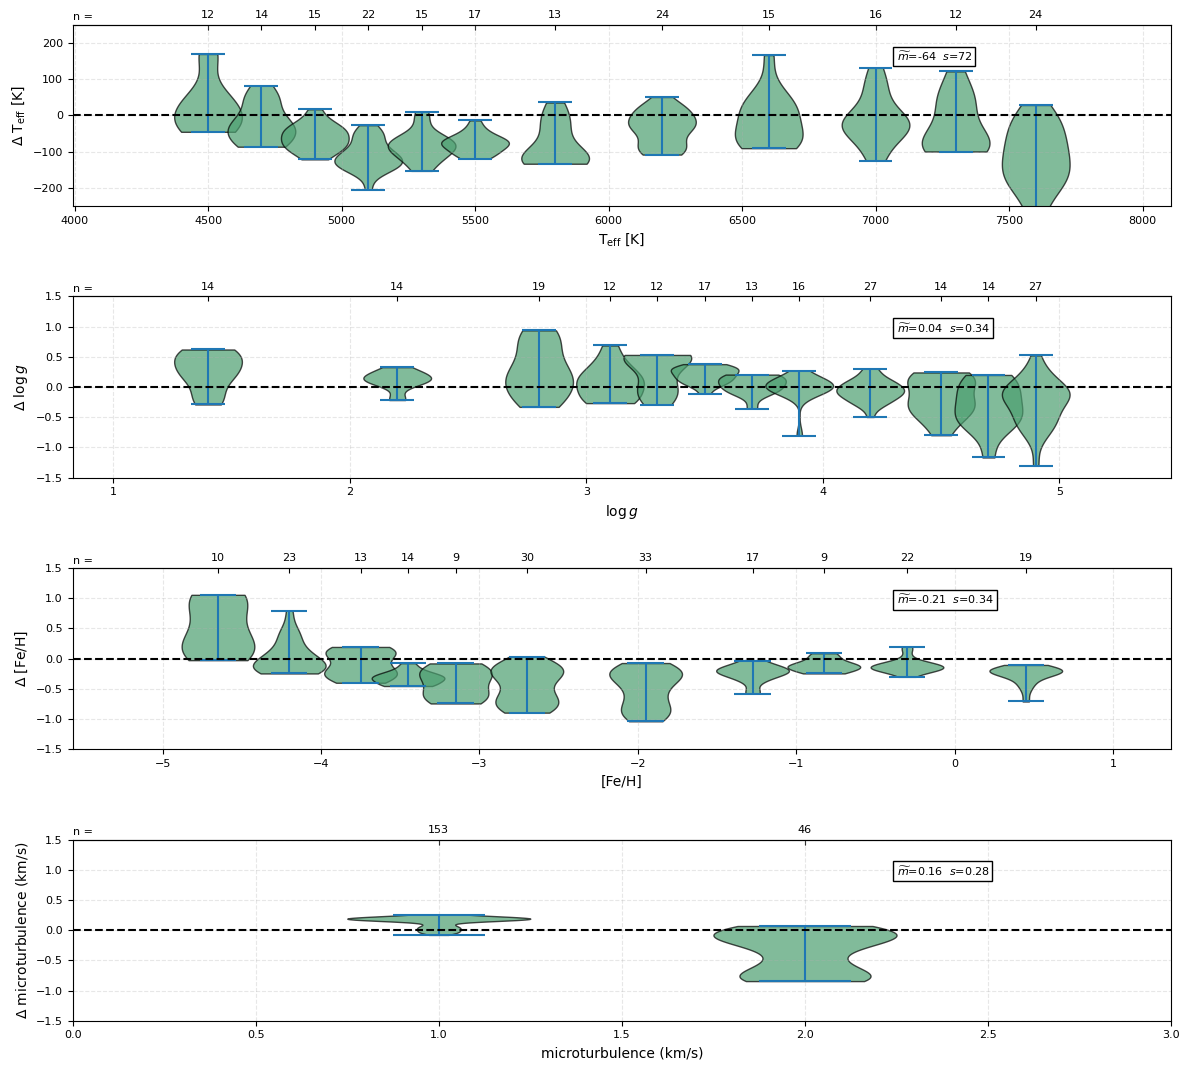

In [8]:
# Binned residual-violin plotting utility (ready to run)
# Default parameter names & mapping from short keys to column indices
param_names_default = ['Teff (K)', 'logg', '[Fe/H]', 'microturbulence']
label_key_to_idx = {'teff': 0, 'logg': 1, 'feh': 2, 'micro': 3}

def plot_resid_violin_binned(label_keys=None,
                             preds=None,
                             truths=None,
                             n_bins=10,
                             bin_method='quantile',   # 'quantile' or 'linear'
                             min_count=5,
                             y_lims=None,
                             savename=None,
                             figsize_per_row=2.7):
    """
    Make binned violin plots of residuals (pred - truth) for each requested label.
    - label_keys: list like ['teff','logg','feh','micro'] or None to use all defaults
    - preds, truths: numpy arrays shape (N, n_params). If None, uses globals 'preds' and 'truths'.
    - n_bins: number of bins along the target domain (if domain has <= n_bins unique values, uses those unique values)
    - bin_method: 'quantile' (equal-count bins) or 'linear' (equal-width bins)
    - min_count: minimum samples in a bin to include it in the plot
    - y_lims: list/tuple of per-parameter +/- y-limits (optional). If None, computed automatically per parameter
    - savename: optional path to save the figure
    """
    # grab preds/truths from globals if not provided
    preds = preds if preds is not None else globals().get('preds', None)
    truths = truths if truths is not None else globals().get('truths', None)
    if preds is None or truths is None:
        raise RuntimeError("preds and truths not found: pass them or run evaluation cell first.")

    preds = np.asarray(preds)
    truths = np.asarray(truths)
    if preds.shape != truths.shape:
        raise RuntimeError(f"preds and truths must have same shape, got {preds.shape} vs {truths.shape}")

    n_params = preds.shape[1]
    if label_keys is None:
        # default order: teff, logg, feh, micro (truncate to available params)
        label_keys = ['teff','logg','feh','micro'][:n_params]

    # prepare figure
    n_plots = len(label_keys)
    fig, axes = plt.subplots(n_plots, 1, figsize=(12, n_plots * figsize_per_row), squeeze=False)
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=1)

    for i, key in enumerate(label_keys):
        ax = axes[i,0]
        idx = label_key_to_idx.get(key, None)
        if idx is None or idx >= n_params:
            raise KeyError(f"Unknown or out-of-range label key '{key}' (requested index {idx})")

        pretty_name = key
        if key == 'teff':
            pretty_name = 'T$_{\\mathrm{eff}}$ [K]'
        elif key == 'feh':
            pretty_name = '[Fe/H]'
        elif key == 'logg':
            pretty_name = '$\\log{g}$'
        elif key == 'micro':
            pretty_name = 'microturbulence (km/s)'

        tgt_vals = truths[:, idx]
        diff = preds[:, idx] - truths[:, idx]

        # Choose bin edges
        unique_vals = np.unique(tgt_vals)
        if unique_vals.size <= n_bins:
            # use exact unique values as "bins"
            bin_centers = unique_vals
            box_data = []
            box_positions = []
            for val in bin_centers:
                sel = np.where(tgt_vals == val)[0]
                if len(sel) >= min_count:
                    box_positions.append(val)
                    box_data.append(diff[sel])
            if len(box_positions) == 0:
                ax.text(0.5, 0.5, 'No bins with >= min_count samples', ha='center', va='center')
                continue
            box_positions = np.array(box_positions)
            box_width = np.mean(np.diff(np.sort(box_positions))) / 2 if box_positions.size>1 else 0.5
        else:
            # regular binning
            if bin_method == 'quantile':
                quantiles = np.linspace(0, 1, n_bins + 1)
                edges = np.unique(np.quantile(tgt_vals, quantiles))
                # if edges collapsed because of duplicates, fallback to linear
                if len(edges) <= 2:
                    edges = np.linspace(tgt_vals.min(), tgt_vals.max(), n_bins + 1)
            else:
                edges = np.linspace(tgt_vals.min(), tgt_vals.max(), n_bins + 1)

            box_positions = []
            box_data = []
            for j in range(len(edges)-1):
                low, high = edges[j], edges[j+1]
                if j == len(edges)-2:
                    # include rightmost edge
                    sel = np.where((tgt_vals >= low) & (tgt_vals <= high))[0]
                else:
                    sel = np.where((tgt_vals >= low) & (tgt_vals < high))[0]
                if len(sel) >= min_count:
                    center = (low + high) / 2.0
                    box_positions.append(center)
                    box_data.append(diff[sel])
            box_positions = np.array(box_positions)
            if box_positions.size == 0:
                ax.text(0.5, 0.5, 'No bins with >= min_count samples', ha='center', va='center')
                continue
            # choose a sensible width
            if box_positions.size > 1:
                spacing = np.mean(np.diff(np.sort(box_positions)))
                box_width = spacing * 0.9
            else:
                # single bin
                span = (edges[-1] - edges[0]) if edges is not None else 1.0
                box_width = span * 0.2

        # Plot violins
        parts = ax.violinplot(box_data, positions=box_positions, widths=box_width,
                              showextrema=True, showmeans=False)
        for pc in parts['bodies']:
            pc.set_facecolor('#4C9F70')
            pc.set_edgecolor('black')
            pc.set_alpha(0.7)
        if 'cmedians' in parts:
            parts['cmedians'].set_color('black')

        # Annotate median and standard deviation of residuals (global for that parameter)
        med = np.median(diff)
        std_ = np.std(diff)
        if 'eff' in pretty_name:
            ann = '$\\widetilde{m}$=%0.0f  $s$=%0.0f' % (med, std_)
        elif 'rad' in pretty_name:
            ann = '$\\widetilde{m}$=%0.1f  $s$=%0.1f' % (med, std_)
        else:
            ann = '$\\widetilde{m}$=%0.2f  $s$=%0.2f' % (med, std_)
        ax.annotate(ann, (0.75, 0.8), size=8, xycoords='axes fraction', bbox=bbox_props)

        # Axes labels, grid, zero line
        ax.set_xlabel(f'{pretty_name}')
        ax.set_ylabel(r'$\Delta$ %s' % pretty_name)
        ax.axhline(0, linewidth=1.5, c='black', linestyle='--')

        # y-limits
        if y_lims is not None:
            # if y_lims provided as list per param, pick ith or scalar
            if isinstance(y_lims, (list, tuple, np.ndarray)):
                if len(y_lims) >= len(label_keys):
                    yl = y_lims[i]
                else:
                    yl = y_lims[0]
            else:
                yl = y_lims
            ax.set_ylim(-yl, yl)
        else:
            # auto compute: a few times the median absolute deviation / percentile
            rng = np.percentile(np.abs(diff), 98)
            yl = max(rng * 1.2, np.std(diff) * 3, 1e-8)
            ax.set_ylim(-yl, yl)

        # x-limits & ticks
        ax.set_xlim(np.min(box_positions) - box_width*2, np.max(box_positions) + box_width*2)
        ax.tick_params(labelsize=8)
        ax.grid(True, linestyle='--', alpha=0.3)

        # Annotate sample size of each bin on top as ticklabels
        ax.text(box_positions[0] - 2*box_width, 1.05 * ax.get_ylim()[1], 'n = ', fontsize=8)
        ax_t = ax.secondary_xaxis('top')
        ax_t.set_xticks(box_positions)
        ax_t.set_xticklabels([len(d) for d in box_data])
        ax_t.tick_params(axis='x', direction='in', labelsize=8)

        # If Teff, set integer ticks
        if key == 'teff':
            tick_positions = ax.get_xticks()
            ax.set_xticklabels([int(x) for x in tick_positions])

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5)

    if savename is not None:
        path = Path(savename)
        fig.savefig(path, facecolor='white', transparent=False, dpi=150, bbox_inches='tight', pad_inches=0.05)
        print(f"Saved figure to {path}")

    plt.show()


# Example call using globals 'preds' and 'truths' computed earlier
# Default: 10 quantile bins, require at least 5 samples per bin
plot_resid_violin_binned(label_keys=['teff','logg','feh','micro'],
                         preds=globals().get('test_preds'),
                         truths=globals().get('test_truths'),
                         n_bins=12,
                         bin_method='quantile',
                         min_count=1,
                         y_lims=[250, 1.5, 1.5, 1.5])

### Metrics table

In [9]:
# Cell: Global Performance Metrics Table
def calculate_global_metrics(preds, truths, param_names=None):
    """
    Calculate global performance metrics for stellar parameter predictions.
    
    Parameters:
    -----------
    preds : np.ndarray
        Predicted values, shape (n_samples, n_parameters)
    truths : np.ndarray  
        True values, shape (n_samples, n_parameters)
    param_names : list, optional
        Names of parameters. If None, uses default stellar parameter names.
    
    Returns:
    --------
    pd.DataFrame
        Metrics table with parameters as rows and metrics as columns
    """
    if param_names is None:
        param_names = ['T_eff (K)', 'log(g)', '[Fe/H]', 'microturbulence (km/s)']
    
    # Ensure we only use available parameters
    n_params = min(preds.shape[1], len(param_names))
    param_names = param_names[:n_params]
    
    metrics_data = []
    
    for i, param_name in enumerate(param_names):
        # Calculate residuals for this parameter
        residuals = preds[:, i] - truths[:, i]
        
        # Calculate metrics
        rmse = np.sqrt(np.mean(residuals**2))  # Root Mean Squared Error
        mae = np.mean(np.abs(residuals))       # Mean Absolute Error  
        std = np.std(residuals)                # Standard deviation of residuals
        mad = stats.median_abs_deviation(residuals, scale='normal')  # Median Absolute Deviation
        
        # Additional useful metrics
        bias = np.mean(residuals)              # Mean bias (systematic offset)
        r2 = 1 - np.var(residuals) / np.var(truths[:, i])  # R-squared
        
        metrics_data.append({
            'Parameter': param_name,
            'RMSE': rmse,
            'MAE': mae, 
            'STD': std,
            'MAD': mad,
            'Bias': bias,
            'R²': r2
        })
    
    return pd.DataFrame(metrics_data)

In [13]:
# Check if predictions exist in globals from previous inference cell
preds = globals().get('test_preds')      # Physical units predictions
truths = globals().get('test_truths')    # Physical units true values

# Calculate metrics table
metrics_df = calculate_global_metrics(preds, truths)
    
# Display the table with nice formatting
print("=" * 80)
print("GLOBAL PERFORMANCE METRICS")
print("=" * 80)
    
# Format the DataFrame for better display
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
    
print(metrics_df.to_string(index=False, float_format='{:.4f}'.format))
    
print("\n" + "=" * 80)
print("METRIC DEFINITIONS:")
print("RMSE: Root Mean Squared Error — measures average magnitude of prediction errors (lower is better)")
print("MAE:  Mean Absolute Error — average absolute difference between prediction and truth (lower is better)") 
print("STD:  Standard deviation of residuals — spread of residuals around their mean(lower is better)")
print("MAD:  Median Absolute Deviation — median spread of residuals, less affected by outliers (lower is better)")
print("Bias: Mean residual, systematic — positive = overprediction, negative = underprediction (closer to 0 is better)")
print("R²:   Coefficient of determination — fraction of variance explained by the model (closer to 1 is better)")
print("=" * 80)

GLOBAL PERFORMANCE METRICS
             Parameter    RMSE     MAE     STD     MAD     Bias     R²
             T_eff (K) 91.2718 75.0237 72.1379 65.1643 -55.9166 0.9950
                log(g)  0.3450  0.2587  0.3448  0.2708   0.0126 0.8785
                [Fe/H]  0.4134  0.3238  0.3421  0.1928  -0.2321 0.9502
microturbulence (km/s)  0.2773  0.2018  0.2760  0.0986   0.0267 0.5714

METRIC DEFINITIONS:
RMSE: Root Mean Squared Error — measures average magnitude of prediction errors (lower is better)
MAE:  Mean Absolute Error — average absolute difference between prediction and truth (lower is better)
STD:  Standard deviation of residuals — spread of residuals around their mean(lower is better)
MAD:  Median Absolute Deviation — median spread of residuals, less affected by outliers (lower is better)
Bias: Mean residual, systematic — positive = overprediction, negative = underprediction (closer to 0 is better)
R²:   Coefficient of determination — fraction of variance explained by the model (c

### Analysing Gradients

In [14]:
def analyze_gradient_history(filepath):
    """
    Analyze gradient norms from a training history file.
    
    Parameters
    ----------
    filepath : str
        Path to the file being analyzed.
    """
    data = np.load(filepath)
    # Check if gradient data exists
    if 'grad_norm_mean' not in data:
        print(f"No gradient data found in the provided data")
        return
    
    grad_mean = data['grad_norm_mean']
    grad_max = data['grad_norm_max'] 
    grad_min = data['grad_norm_min']
    train_loss = data.get('train_loss', None)
        
    epochs = len(grad_mean)
        
    print(f"\n{'-'*60}")
    print(f"Gradient Analysis: {filepath}")
    print(f"{'-'*60}")
    print(f"Training epochs: {epochs}")
    print(f"Gradient norm statistics:")
    print(f"  Mean gradient norm: {np.mean(grad_mean):.6f} ± {np.std(grad_mean):.6f}")
    print(f"  Max gradient norm:  {np.max(grad_max):.6f}")
    print(f"  Min gradient norm:  {np.min(grad_min):.6f}")
        
    # Flag potential issues
    exploding_threshold = 10.0
    vanishing_threshold = 1e-6
        
    exploding_epochs = np.where(grad_max > exploding_threshold)[0]
    vanishing_epochs = np.where(grad_min < vanishing_threshold)[0]
        
    if len(exploding_epochs) > 0:
        print(f"  ⚠️  WARNING: Potential exploding gradients detected in {len(exploding_epochs)} epochs")
        print(f"      Affected epochs: {exploding_epochs[:10]}")  # Show first 10
        if len(exploding_epochs) > 10:
            print(f"      ... and {len(exploding_epochs) - 10} more")
        
    if len(vanishing_epochs) > 0:
        print(f"  ⚠️  WARNING: Potential vanishing gradients detected in {len(vanishing_epochs)} epochs")
        print(f"      Affected epochs: {vanishing_epochs[:10]}")  # Show first 10
        if len(vanishing_epochs) > 10:
            print(f"      ... and {len(vanishing_epochs) - 10} more")
        
    # Check for gradient norm trends
    if len(grad_mean) > 10:
        early_mean = np.mean(grad_mean[:len(grad_mean)//3])
        late_mean = np.mean(grad_mean[2*len(grad_mean)//3:])
            
        if late_mean / early_mean < 0.1:
            print(f"  ⚠️  WARNING: Gradient norms decreased significantly during training")
            print(f"      Early mean: {early_mean:.6f}, Late mean: {late_mean:.6f}")
        elif late_mean / early_mean > 10.0:
            print(f"  ⚠️  WARNING: Gradient norms increased significantly during training")
            print(f"      Early mean: {early_mean:.6f}, Late mean: {late_mean:.6f}")
        
    # Assessment
    mean_grad_norm = np.mean(grad_mean)
    if mean_grad_norm > 1.0:
        print(f"  📊 ASSESSMENT: Normal to large gradient norms (good for learning)")
    elif mean_grad_norm > 0.01:
        print(f"  📊 ASSESSMENT: Moderate gradient norms (acceptable)")
    elif mean_grad_norm > 1e-4:
        print(f"  📊 ASSESSMENT: Small gradient norms (may indicate slow learning)")
    else:
        print(f"  📊 ASSESSMENT: Very small gradient norms (potential vanishing gradient issue)")
        
    return grad_mean, grad_max, grad_min, train_loss

In [15]:
def plot_gradient_analysis(filepath: str):
    """
    Plot gradient analysis for a training history file.

    Parameters
    ----------
    filepath : str
        Path to the history file being analyzed.
    """
    # Load data
    grad_mean, grad_max, grad_min, train_loss = analyze_gradient_history(filepath)
    epochs = np.arange(1, len(grad_mean) + 1)

    # Create figure and axes
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Gradient Norm Analysis', fontsize=16, weight='bold')

    # ---- (1) Gradient norms over time ----
    axes[0, 0].plot(epochs, grad_mean, label='Mean', linewidth=2)
    axes[0, 0].plot(epochs, grad_max, '--', alpha=0.7, label='Max')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Gradient Norm')
    axes[0, 0].set_title('Gradient Norms Over Time')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # ---- (2) Gradient scale ratio (max/min) ----
    grad_ratio = np.array(grad_max) / np.maximum(grad_min, 1e-8)
    axes[0, 1].plot(epochs, grad_ratio, color='orange', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Max / Min Gradient Norm')
    axes[0, 1].set_title('Gradient Scale Ratio Over Time')
    axes[0, 1].grid(True, alpha=0.3)

    # ---- (3) Distribution of gradient norms ----
    axes[1, 0].hist(grad_mean, bins=20, color='slateblue', alpha=0.7)
    axes[1, 0].set_xlabel('Mean Gradient Norm')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Distribution of Gradient Norms')
    axes[1, 0].grid(True, alpha=0.3)

    # ---- (4) Gradient norm vs training loss ----
    axes[1, 1].scatter(grad_mean, train_loss, alpha=0.7, color='teal')
    axes[1, 1].set_xlabel('Mean Gradient Norm')
    axes[1, 1].set_ylabel('Training Loss')
    axes[1, 1].set_title('Gradient Norm vs Training Loss')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    return



------------------------------------------------------------
Gradient Analysis: ../pytorch_models/cnn_model.history.npz
------------------------------------------------------------
Training epochs: 20
Gradient norm statistics:
  Mean gradient norm: 1.797371 ± 0.481046
  Max gradient norm:  4.972549
  Min gradient norm:  0.503516
  📊 ASSESSMENT: Normal to large gradient norms (good for learning)


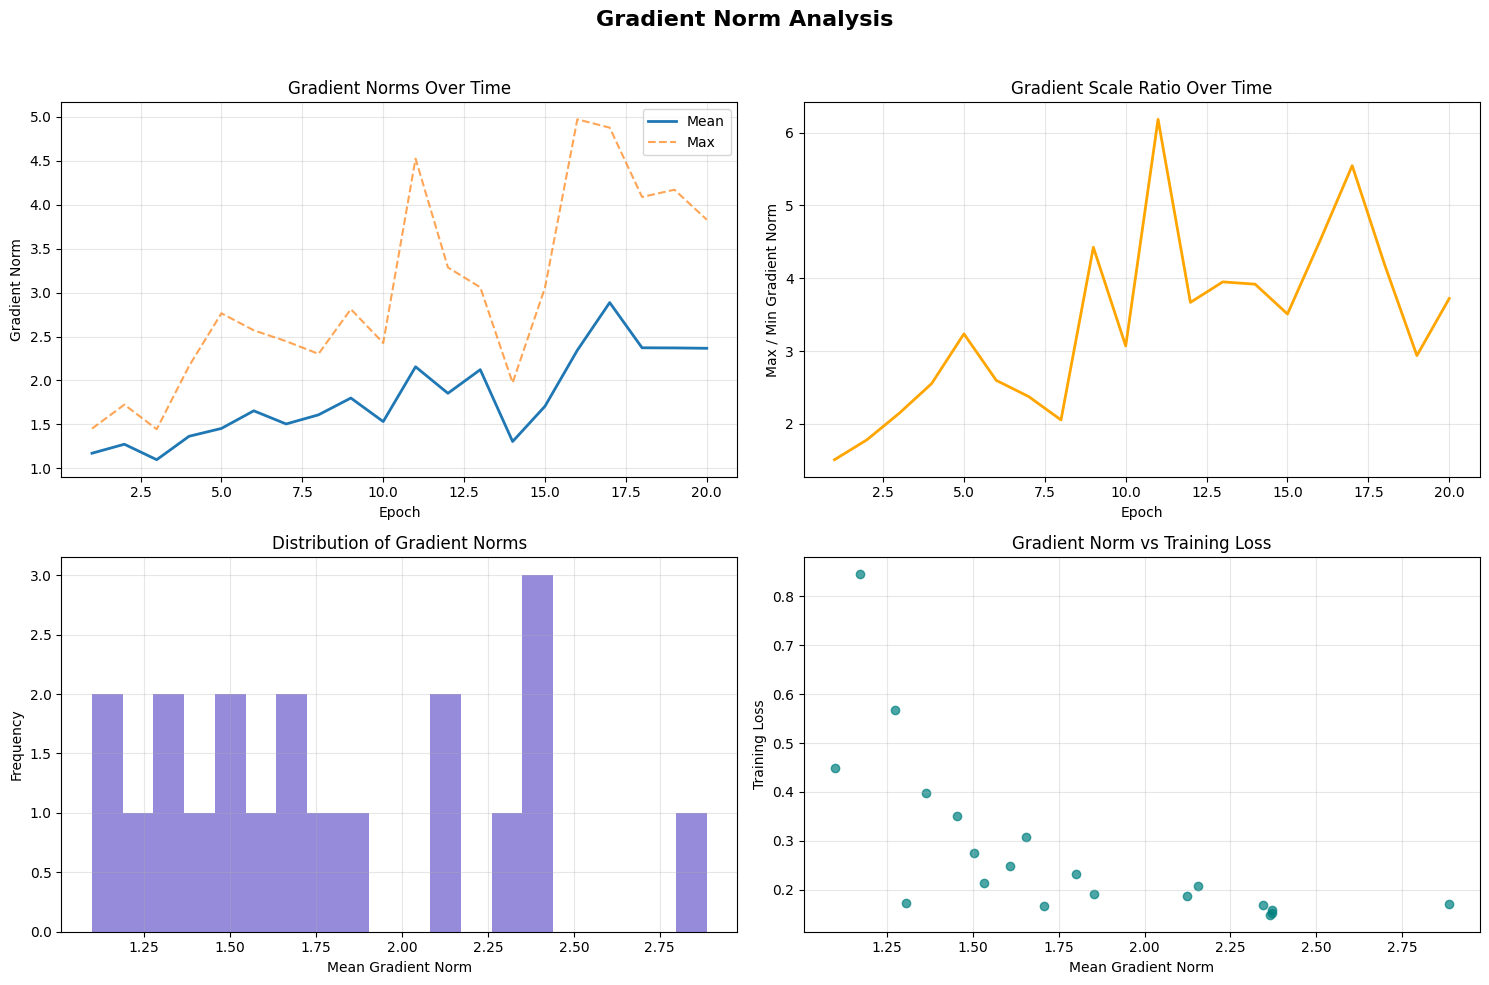

In [16]:
plot_gradient_analysis(HISTORY_PATH)